In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
class LogisticRegression:
    
    def __init__(self, data, train_X = None, train_y = None, test_X = None, test_y = None, percentage=0.5, lr=0.01, max_iter=10000, beta=0.99, reg_term=0):  # percentage = train/cv+test split
        self.data = data
        self.percentage = percentage
        self.gradient_values, self.train_acc_values, self.cv_acc_values = [], [], []
        if train_X is None and test_X is None:
            self.train_X, self.train_y, self.sub_X, self.sub_y = self.split_data(self.data, self.percentage)
        else:
            self.train_X, self.train_y, self.sub_X, self.sub_y = train_X, train_y, test_X, test_y
            
        self.test_X, self.test_y, self.cv_X, self.cv_y = self.split_data(pd.concat([self.sub_X,self.sub_y], axis=1), 0.5)
        self.thetas = self.gradient_descent(self.train_X.values, self.train_y.values, self.cv_X.values, self.cv_y.values, learning_rate=lr, max_iter=max_iter, beta=beta, reg_term=reg_term)
        
        self.testing_accuracy = self.get_test_acc(self.test_X.values, self.test_y.values, self.thetas)
        
    def split_data(self, data, percentage=0.5):
        val = np.random.rand(len(data)) < percentage  #splits data and sorts into x, y values
        train = data[val]
        test = data[~val]

        train_X = train.iloc[:, :-1]
        train_y = train.iloc[:, -1]

        test_X = test.iloc[:, :-1]
        test_y = test.iloc[:, -1]
        return train_X, train_y ,test_X, test_y
    
    def predict_proba(self, X, theta):
        return self.sigmoid(np.dot(X, theta))

    def predict(self, X, theta):
        prediction = self.predict_proba(X, theta)
        predict_arr = []
        for i in prediction:
            if i>=0.5:
                predict_arr.append(1)
            else:
                predict_arr.append(0)

        return predict_arr

    def accuracy(self, predict_arr, y):
        correct = 0
        for i,j in zip(predict_arr, y):
            if i==j[0]:
                correct+=1
        return correct/len(y)  # accuracy = # tp+tn / total

    def sigmoid(self, x):
        return 1/(1+np.exp(-x))

    def gradient(self, X, y, theta, lambdaa):  # lambdaa is regularization term
        N, D = len(X[0]), len(X[0])
        yh = self.sigmoid(np.dot(X, theta))
        grad = np.dot(X.T, yh-y) / N
        grad[1:] += lambdaa * theta[1:]
        return grad

    def gradient_descent(self, X, y, cv_X, cv_y, learning_rate=0.1, max_iter=10000, beta=0.99, reg_term=0.5):  # attempted termination condition - lack of improvement in cross validation set
        N, D = len(X[0]), len(X[0])
        theta = np.zeros((len(X[0]), 1))
        y = np.reshape(y, (-1,1))  # creates two-dimensional array
        cv_y = np.reshape(cv_y, (-1,1))
        iterate, cv_acc, prev_cv_acc, d_theta = 0, 0, 0, 0
        max_cv_acc = 0  # maximum cross validation accuracy - records thetas at highest cv_acc 
        best_theta = theta
        g = np.inf
        eps = 1e-2
        while (np.linalg.norm(g) > eps):  # can add in 'or cv_acc>=prev_cv_acc-0.03' to stop when gradient becomes too small, 0.03 gives buffer
            g = self.gradient(X, y, theta, reg_term)
            d_theta = (1-beta)*g + beta*d_theta  # momentum
            theta = theta-learning_rate*d_theta
            
            if iterate % 10 == 0:
                cv_pred = self.predict(cv_X, theta)
                prev_cv_acc = cv_acc
                cv_acc = self.accuracy(cv_pred, cv_y)
                train_pred = self.predict(X, theta)
                train_acc = self.accuracy(train_pred, y)
            if cv_acc >= max_cv_acc:  # checks if maximum accuracy thus far
                max_cv_acc = cv_acc
                best_theta = theta
            iterate+=1
            self.gradient_values.append(np.linalg.norm(g))
            self.train_acc_values.append(train_acc)
            self.cv_acc_values.append(cv_acc)
#             if iterate % 100 == 0:
#                 print(np.linalg.norm(g)/len(X))
            if iterate > max_iter:  # since it may not always converge, place a hard ceiling on number of iterations
                break
        print(max_cv_acc)
        print(cv_acc)
        return best_theta
    
    def get_test_acc(self, test_X, test_y, thetas):
        test_y = np.reshape(test_y, (-1,1))
        
        return self.accuracy(self.predict(test_X, thetas), test_y)

In [3]:
new_input = pd.read_csv('ionosphere.data', header=None)
new_input[len(new_input.T)-1] = new_input[len(new_input.T)-1].map({'g': 1, 'b':0})
new_input.insert(0, column='Bias', value=1)
log_reg = LogisticRegression(new_input, percentage=0.6)
print(log_reg.testing_accuracy)

0.8484848484848485
0.8181818181818182
0.8142857142857143


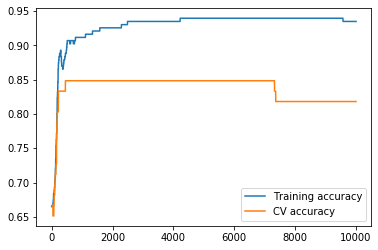

In [4]:
plt.figure()
plt.plot(log_reg.train_acc_values, label = 'Training accuracy')
plt.plot(log_reg.cv_acc_values, label='CV accuracy')
plt.legend()
plt.show()

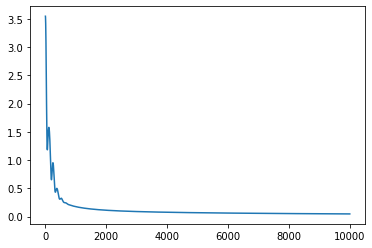

In [5]:
plt.figure(101)
plt.plot(log_reg.gradient_values)
plt.show()

In [6]:
header = ['age','workclass','fnlwgt','education','education_num','marital-status','occupation','relationship','race','sex','capital-gain','capital-loss','hours-per-week','native-country','income']
train_df = pd.read_csv('adult.data', names = header)
train_df.insert(0, column='Bias', value=1)
test_df = pd.read_csv('adult.test', comment = '|', names = header)
test_df.insert(0, column='Bias', value=1)
adult = pd.concat([test_df, train_df])

adult.isnull().sum() #no NaN 

for i,j in zip(adult.columns,(adult.values.astype(str) == ' ?').sum(axis = 0)):
    if j > 0:
        print(str(i) + ': ' + str(j) + ' missing')
        
all_data = [train_df, test_df]
for data in all_data:
    for i in data.columns:
        data[i].replace(' ?', np.nan, inplace=True)
    data.dropna(inplace=True)
    
adult['income']=adult['income'].map({' <=50K': 0, ' >50K': 1, ' <=50K.': 0, ' >50K.': 1})

train_df['income'] = train_df['income'].map({' <=50K': 0, ' >50K': 1})
test_df['income'] = test_df['income'].map({' <=50K.': 0, ' >50K.': 1}) 

columnTransformer = ColumnTransformer([('encoder', OneHotEncoder(), [2,4,6,7,8,9,10,14])], remainder='passthrough')
onehotencoder = OneHotEncoder()
X_train_adult = columnTransformer.fit_transform(train_df).toarray()
X_test_adult = columnTransformer.transform(test_df).toarray()


y_train_adult = train_df.iloc[:,-1]
y_test_adult = test_df.iloc[:,-1]
# Encode '<=50k' as 0, '>50k' as 1

# y_train_adult = y_train_adult.map({' <=50K': 0, ' >50K': 1})
# y_test_adult = y_test_adult.map({' <=50K.': 0, ' >50K.': 1})
# y_train_adult=y_train_adult.array
# y_test_adult=y_test_adult.array

workclass: 2799 missing
occupation: 2809 missing
native-country: 857 missing


In [7]:
# y_test_adult = y_test_adult[:-1]
# y_train_adult = y_train_adult[:-1]
new_X_train_adult = pd.DataFrame(data = X_train_adult, index = [index for index, row in y_train_adult.iteritems()], columns = [i for i in range(X_train_adult.shape[1])])
new_X_test_adult = pd.DataFrame(data = X_test_adult, index = [index for index, row in y_test_adult.iteritems()], columns = [i for i in range(X_test_adult.shape[1])])
def df_rescale(data):
    for col in data:
        this_max = data.iloc[:, col].max()
        this_min = data.iloc[:, col].min()
        if (this_max != this_min):
            data.iloc[:, col] -= this_min
            data.iloc[:, col] /= data.iloc[:, col].max()
    return data

new_X_train_adult = df_rescale(new_X_train_adult)
new_X_test_adult = df_rescale(new_X_test_adult)

In [ ]:
adult_log_reg = LogisticRegression(new_input, train_X = new_X_train_adult, train_y = y_train_adult, test_X = new_X_test_adult, test_y = y_test_adult, max_iter=5000, percentage=0.6, lr=0.01, reg_term=0, beta=0.99)
print(adult_log_reg.testing_accuracy)

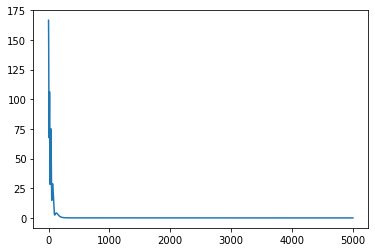

In [59]:
plt.figure(100)
plt.plot(adult_log_reg.gradient_values)
plt.show()

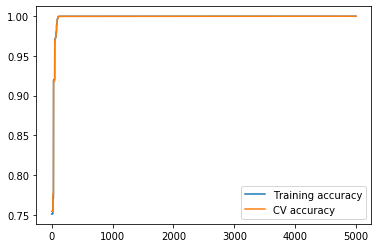

In [60]:
plt.figure(300)
plt.plot(adult_log_reg.train_acc_values, label = 'Training accuracy')
plt.plot(adult_log_reg.cv_acc_values, label='CV accuracy')
plt.legend()
plt.show()